# Overview

## Output Files:
- SQGDP9_US_2005_2022.csv
- Aon_US_Damage_2004_to_2022.csv
- Aon_US_Damage_2004_to_2022_dropped.csv
- rsmeans_wtavgs_st.csv
- nationwide_constr_spend_qtr.csv

## BEA Construction Data

### Input:
- SQGDP9_AK_2005_2022.csv
- SQGDP9_AL_2005_2022.csv
- ...
- SQGDP9_WV_2005_2022.csv
- SQGDP9_WY_2005_2022.csv

### Output:
- SQGDP9_US_2005_2022.csv

## AON Damages Data

### Input: 
- Aon Damages by Time Location and Amount 2004 to 2022.xlsx

### Output:  
- Aon_US_Damage_2004_to_2022.csv
- Aon_US_Damage_2004_to_2022_dropped.csv

## RSMeans Data

### Input:
- rsmeans.pkl

### Output:
- rsmeans.csv

## US Construction GDP Data

### Input:
- nationwide_constr_spend.xlsx

### Output:
- nationwide_constr_spend_qtr.csv

## Preliminaries

In [1]:
# set to true to create output files again
create_output_files = False
chunk_size = 200000

In [2]:
import pandas as pd
import numpy as np
import re
import glob
import os
import pickle
import datetime
from pandas.tseries.offsets import MonthEnd
import matplotlib.pyplot as plt
from scipy.stats import rvs_ratio_uniforms
from sympy import *
import sympy
import scipy.stats as stats

### Files and Directories

In [3]:
# Base
#base_dir = "./Rich"
base_dir = '/content/drive/MyDrive/environment'
out_dir = os.path.join(base_dir,"out2")

# FEMA
#fema_in_file = "HELP HELP.xlsx"
fema_in_file = "HELP HELP2.xlsx"
fema_fed_out_file = "fema_fed_by_month"     # .csv added later
fema_st_out_file = "fema_state_by_month"    # .csv added later
fema_tot_out_file = "fema_total_by_month"   # .csv added later

fema_err_dt1_out_file = "fema_err_start_date.csv"
fema_err_dt2_out_file = "fema_err_end_date.csv"
fema_err_dt2_lt_dt1_file = "fema_err_start_date_gt_end_date.csv"
fema_err_tot_spend = "fema_err_total_spend.csv"
fema_err_fed_spend = "fema_err_fed_spend.csv"
fema_err_st_spend = "fema_err_state_spend.csv"

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Process FEMA

In [5]:
dffema = None   # master set
dti = None
df = None       # chunk set
use_gaussian = True
cdfbins = 1000
cdftot = 1000000
cdf = None

In [6]:
def clean():
    global dffema
    dffema["START YR"] = pd.to_numeric(dffema["START YR"], 
                                        errors='coerce').fillna(0).astype('int')
    dffema["START MO"] = pd.to_numeric(dffema["START MO"], 
                                        errors='coerce').fillna(0).astype('int')
    dffema["END YR"] = pd.to_numeric(dffema["END YR"], 
                                    errors='coerce').fillna(0).astype('int')
    dffema["END MO"] = pd.to_numeric(dffema["END MO"], 
                                    errors='coerce').fillna(0).astype('int')
    baddates = (dffema["END MO"]==0)
    dffema.loc[baddates,"END YR"] = dffema[baddates]["START YR"]
    dffema.loc[baddates,"END MO"] = dffema[baddates]["START MO"]

    dferr = dffema[pd.to_datetime(dffema["START MO"].astype(str) + " " \
                                    + dffema["START YR"].astype(str), 
                                    errors="coerce").isna()]
    if len(dferr) > 0:
        dferr.to_csv(os.path.join(base_dir,fema_err_dt1_out_file))

    dferr = dffema[pd.to_datetime(dffema["END MO"].astype(str) + " " \
                                    + dffema["END YR"].astype(str),
                                    errors="coerce").isna()]
    if len(dferr) > 0:
        dferr.to_csv(os.path.join(base_dir,fema_err_dt2_out_file))

    dferr = dffema[(pd.to_datetime(dffema['END YR'].astype(str) \
                                   + " "+dffema['END MO'].astype(str))) \
                   < (pd.to_datetime(dffema['START YR'].astype(str) \
                                     + " " + dffema['START MO'].astype(str)))]
    if len(dferr) > 0:
        dferr.to_csv(os.path.join(base_dir,fema_err_dt2_lt_dt1_file))

    dffema = dffema[pd.to_datetime(dffema["START MO"].astype(str) + \
                                    " " + dffema["START YR"].astype(str), 
                                    errors="coerce").notna()]
    dffema = dffema[pd.to_datetime(dffema["END MO"].astype(str) + \
                                    " " + dffema["END YR"].astype(str),
                                    errors="coerce").notna()]
    dffema = dffema[(pd.to_datetime(dffema['END YR'].astype(str) \
                                   + " "+dffema['END MO'].astype(str))) \
                   >= (pd.to_datetime(dffema['START YR'].astype(str) \
                                     + " " + dffema['START MO'].astype(str)))]

    dffema["TOTAL PROJECT SPEND"] = pd.to_numeric(dffema["TOTAL PROJECT SPEND"],
                                                    errors='coerce').fillna(0).astype('float').round(2)
    dffema["FED SPEND"] = pd.to_numeric(dffema["FED SPEND"], 
                                        errors='coerce').fillna(0).astype('float').round(2)
    dffema["STATE SPEND"] = pd.to_numeric(dffema["STATE SPEND"], 
                                            errors='coerce').fillna(0).astype('float').round(2)


In [7]:
def create_dates_index():
    global dffema
    global dti
    dti = pd.date_range(start=pd.to_datetime(dffema["START MO"].astype(str) + \
                                            " " + dffema["START YR"].astype(str)).min(),
                        end=pd.to_datetime(dffema["END MO"].astype(str) + \
                                            " " + dffema["END YR"].astype(str),
                                            format="%m %Y").max()+MonthEnd(0),
                        freq='M').strftime("%Y-%m")

In [8]:
def build_gassian_prototype():
    global cdf
    seed = 47563
    rng = np.random.default_rng(seed)

    mu = cdfbins/2
    sigma = cdfbins/6
    
    a, b = (0 - mu) / sigma, ((cdfbins-1) - mu) / sigma
    
    cdf = stats.truncnorm.rvs(a,b,loc=mu,scale=sigma,
                              size=cdftot,random_state=rng).round().astype(int)
    _ = plt.hist(cdf,bins=np.arange(cdfbins))
    cdf = np.bincount(cdf)
    for i in np.arange(cdfbins):
         if i == 0:
             continue
         cdf[i] += cdf[i-1]

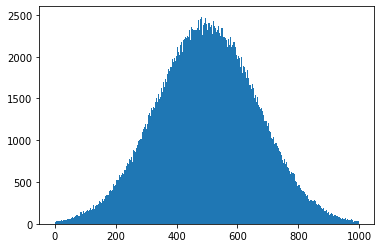

In [9]:
build_gassian_prototype()

In [10]:
dffema = pd.DataFrame(pd.read_excel(os.path.join(base_dir,fema_in_file),
                                    header=1,
                                    sheet_name='HELP',
                                    usecols=np.arange(12).tolist()))
headers = dffema.columns
dummy_index = dffema.index[-1]+1
clean()
create_dates_index()
display(dffema)
dffema_len = len(dffema)
dffema_orig = dffema.copy()

,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,FED SPEND,STATE SPEND
0,PUBLIC ASSISTANCE,Coastal Storm,Statewide,CO,2005,9,2005,9,1,1039431.28,1039431.28,0.00
1,PUBLIC ASSISTANCE,Fire,Rosebud,MT,2012,8,2012,8,1,2664.51,1998.38,666.13
2,PUBLIC ASSISTANCE,Fire,Statewide,MT,2012,8,2012,8,1,22914.27,17185.70,5728.57
3,PUBLIC ASSISTANCE,Tornado,Lincoln,OK,1999,5,1999,5,1,0.00,0.00,0.00
4,PUBLIC ASSISTANCE,Tornado,Creek,OK,1999,5,1999,5,1,70000.00,70000.00,0.00
5,PUBLIC ASSISTANCE,Tornado,Logan,OK,1999,5,1999,5,1,187500.00,187500.00,0.00
6,PUBLIC ASSISTANCE,Tornado,Oklahoma,OK,1999,5,1999,5,1,250000.00,250000.00,0.00
7,PUBLIC ASSISTANCE,Tornado,Statewide,OK,1999,5,1999,5,1,500000.00,500000.00,0.00
8,PUBLIC ASSISTANCE,Tornado,McClain,OK,1999,5,1999,5,1,562500.00,562500.00,0.00
9,PUBLIC ASSISTANCE,Tornado,Grady,OK,1999,5,1999,5,1,1000000.00,1000000.00,0.00


In [11]:
def create_spend_report(colspend,display_result=True,save=False,test_sums=False):
    global dffema
    # update single month
    dffema.loc[dffema["months"]==1,"spend"] = dffema[dffema["months"]==1][colspend]

    # update first month in multi-month
    criteria = (dffema["mindex"]==0) & (dffema["months"]>1)
    dffema.loc[criteria,"spend"] = \
    dffema[criteria].apply(lambda x: (round((cdf[x["fraction"]-1]/cdftot)*x[colspend],2)),axis=1)
    
    # update non-first months in multi-month
    criteria = (dffema["mindex"]>0) & (dffema["months"]>1)
    dffema.loc[criteria,"spend"] = \
        dffema[criteria].apply(lambda x: (round(((cdf[(x["mindex"]+1)*x["fraction"]-1] \
                                                - cdf[x["mindex"]*x["fraction"]-1])/cdftot)*x[colspend],2)),axis=1)

    # adjust "middle" element to compensate for rounding error
    tmp = pd.DataFrame(dffema[dffema["months"]>1].groupby(axis=0,level=0)["spend"].sum())
    dffema.loc[(dffema["months"]>1) \
                   & (dffema["mindex"] == (dffema["months"]/2).astype(int)),"spend"] += \
                        (dffema[(dffema["months"]>1) \
                                & (dffema["mindex"] \
                                   == (dffema["months"]/2).astype(int))][colspend] - tmp["spend"]).round(2)

    if test_sums:
        tmp = pd.DataFrame(dffema[dffema["months"]>1].groupby(axis=0,level=0)["spend"].sum())
        tmp2 = dffema[(dffema["months"]>1) & (dffema["mindex"]==1)]
        tmp3 = tmp2[((tmp2[colspend]-tmp["spend"]).abs().round(2))>0.0]
        if len(tmp3) != 0:
            print("The following rows failed the test...")
            display(tmp3)
        else:
            print("Passed!")
        

    # dispose of columns no longer needed
    dffema = dffema.drop(["TOTAL PROJECT SPEND","FED SPEND",
                          "STATE SPEND","months","mindex",
                          "fraction"],axis=1)

    # add dummy data, so that even date columns without data will be created
    # this row will not be included in final result since index will not match
    # any index in dffema_orig, but it will keep the columns, which is the point
    dffema = dffema.append(pd.DataFrame({"range":dti,"spend":0.0},
                                        index=np.ones(shape=len(dti),dtype=int)*dummy_index,
                                        columns=["range","spend"]))
    
    # pivot spend to date columns
    dffema = dffema.pivot(values="spend",columns="range")
    dffema.columns.name = ""
    
    # rejoin with original data
    dffema = dffema_orig.join(dffema)
    
    if display_result and not test_sums:
        display(dffema)

    if save and not test_sums:
        if colspend == "FED SPEND":
            filename = fema_fed_out_file
        elif colspend == "STATE SPEND":
            filename = fema_st_out_file
        else:
            filename = fema_tot_out_file
        print(F"file written to: {os.path.join(base_dir,filename+'.csv')}")
        dffema.to_csv(os.path.join(base_dir,filename+".csv"))

In [12]:
def prep():
    global dffema
    dffema = dffema_orig.copy()

    # add range column (list of n months from start to end, formate YYYY-MM)
    dt1 = pd.to_datetime(dffema["START MO"].astype(str) + " " \
                            + dffema["START YR"].astype(str))
    dt2 = pd.to_datetime(dffema["END MO"].astype(str) + " " \
                            + dffema["END YR"].astype(str)) + MonthEnd(0)
    dffema["range"] = [pd.date_range(a, b, freq='M').strftime("%Y-%m").tolist() for a, b in zip(dt1, dt2)]

    # add months column (n, single number per row, not a list)
    dffema["months"] = dffema["range"].apply(len)

    # add mindex column (0 to n-1)
    dffema["mindex"] = dffema["months"].apply(np.arange)

    # add spend column (list of n 0.0's, placeholder for the calculated spend later
    dffema["spend"] = dffema["months"].apply(np.zeros)

    # drop all but the above 4 columns + index
    dffema = dffema.drop(["FUND SOURCE","TYPE","COUNTY","STATE","START YR","START MO","END YR","END MO","NUMBER OF MONTHS"],axis=1)

    # explode date, index and spend (each is a list with n elements)
    dffema = dffema.explode(["range","mindex","spend"])
    dffema["spend"] = dffema["spend"].astype(float)

    # add fraction column
    dffema["fraction"] = ((1/dffema["months"]).astype(float) * cdfbins).astype(int)

In [13]:
prep()
create_spend_report("TOTAL PROJECT SPEND")

,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03
0,PUBLIC ASSISTANCE,Coastal Storm,Statewide,CO,2005,9,2005,9,1,1039431.28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,PUBLIC ASSISTANCE,Fire,Rosebud,MT,2012,8,2012,8,1,2664.51,...,NaN,NaN,2664.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,PUBLIC ASSISTANCE,Fire,Statewide,MT,2012,8,2012,8,1,22914.27,...,NaN,NaN,22914.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,PUBLIC ASSISTANCE,Tornado,Lincoln,OK,1999,5,1999,5,1,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,PUBLIC ASSISTANCE,Tornado,Creek,OK,1999,5,1999,5,1,70000.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,PUBLIC ASSISTANCE,Tornado,Logan,OK,1999,5,1999,5,1,187500.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,PUBLIC ASSISTANCE,Tornado,Oklahoma,OK,1999,5,1999,5,1,250000.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,PUBLIC ASSISTANCE,Tornado,Statewide,OK,1999,5,1999,5,1,500000.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,PUBLIC ASSISTANCE,Tornado,McClain,OK,1999,5,1999,5,1,562500.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,PUBLIC ASSISTANCE,Tornado,Grady,OK,1999,5,1999,5,1,1000000.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
prep()
create_spend_report("FED SPEND")

,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03
0,PUBLIC ASSISTANCE,Coastal Storm,Statewide,CO,2005,9,2005,9,1,1039431.28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,PUBLIC ASSISTANCE,Fire,Rosebud,MT,2012,8,2012,8,1,2664.51,...,NaN,NaN,1998.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,PUBLIC ASSISTANCE,Fire,Statewide,MT,2012,8,2012,8,1,22914.27,...,NaN,NaN,17185.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,PUBLIC ASSISTANCE,Tornado,Lincoln,OK,1999,5,1999,5,1,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,PUBLIC ASSISTANCE,Tornado,Creek,OK,1999,5,1999,5,1,70000.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,PUBLIC ASSISTANCE,Tornado,Logan,OK,1999,5,1999,5,1,187500.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,PUBLIC ASSISTANCE,Tornado,Oklahoma,OK,1999,5,1999,5,1,250000.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,PUBLIC ASSISTANCE,Tornado,Statewide,OK,1999,5,1999,5,1,500000.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,PUBLIC ASSISTANCE,Tornado,McClain,OK,1999,5,1999,5,1,562500.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,PUBLIC ASSISTANCE,Tornado,Grady,OK,1999,5,1999,5,1,1000000.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
prep()
create_spend_report("STATE SPEND")

,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03
0,PUBLIC ASSISTANCE,Coastal Storm,Statewide,CO,2005,9,2005,9,1,1039431.28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,PUBLIC ASSISTANCE,Fire,Rosebud,MT,2012,8,2012,8,1,2664.51,...,NaN,NaN,666.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,PUBLIC ASSISTANCE,Fire,Statewide,MT,2012,8,2012,8,1,22914.27,...,NaN,NaN,5728.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,PUBLIC ASSISTANCE,Tornado,Lincoln,OK,1999,5,1999,5,1,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,PUBLIC ASSISTANCE,Tornado,Creek,OK,1999,5,1999,5,1,70000.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,PUBLIC ASSISTANCE,Tornado,Logan,OK,1999,5,1999,5,1,187500.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,PUBLIC ASSISTANCE,Tornado,Oklahoma,OK,1999,5,1999,5,1,250000.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,PUBLIC ASSISTANCE,Tornado,Statewide,OK,1999,5,1999,5,1,500000.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,PUBLIC ASSISTANCE,Tornado,McClain,OK,1999,5,1999,5,1,562500.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,PUBLIC ASSISTANCE,Tornado,Grady,OK,1999,5,1999,5,1,1000000.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
